In [246]:
from util import get_files
from autoreject import read_auto_reject
from mne import read_epochs, viz
from mne.channels import find_layout, find_ch_adjacency
from mne.stats import spatio_temporal_cluster_test, spatio_temporal_cluster_1samp_test, ttest_1samp_no_p
from pathlib import Path
import matplotlib.pylab as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import numpy as np
import pandas as pd
from mne.decoding import (
    SlidingEstimator, GeneralizingEstimator, Scaler,
    cross_val_multiscore, get_coef
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from tqdm.notebook import tqdm
from functools import partial
from copy import copy
from scipy.ndimage import gaussian_filter1d

In [2]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)

In [3]:
MEG_PROC = Path("/home/mszul/datasets/act_mis/MEG/processed/")
BEH_PROC = Path("/home/mszul/datasets/act_mis/BEH/")

In [4]:
all_fif_paths = get_files(MEG_PROC, "*.fif", strings=["autoreject", "zapline", "observation-epo"])
all_ar_paths = get_files(MEG_PROC, "*.h5", strings=["autoreject", "zapline", "observation-epo"])
all_beh_paths = get_files(BEH_PROC, "*.csv")

In [5]:
sens_ix = np.arange(62, 69)

In [6]:
fif_ar_paths = list(zip(all_fif_paths, all_ar_paths))

  0%|          | 0/62 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.
Reading adjacency matrix for ctf275.


KeyboardInterrupt: 

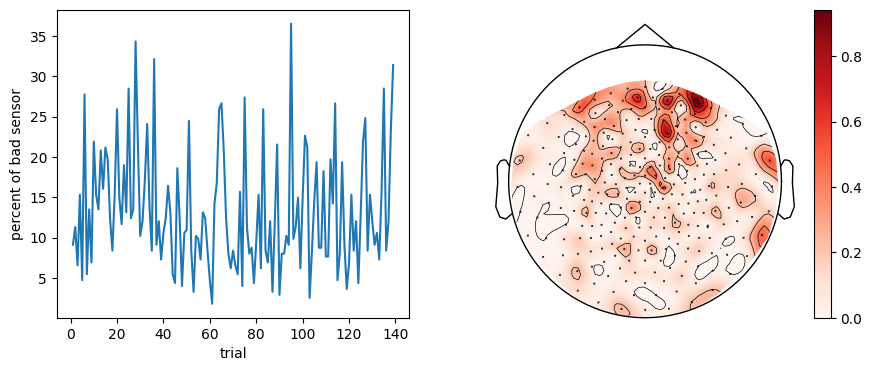

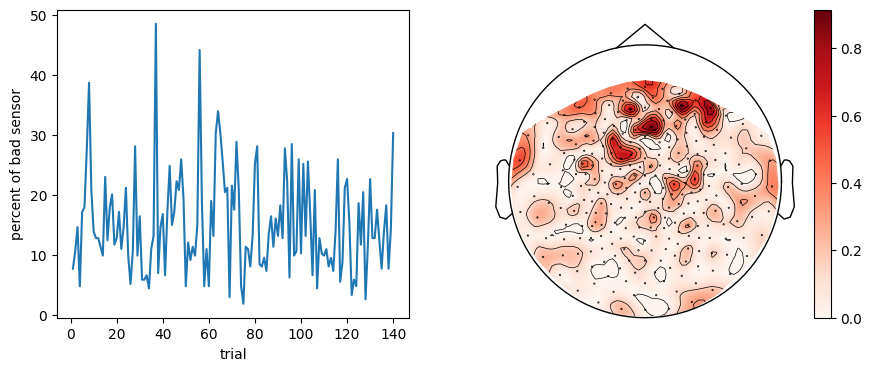

In [7]:
results = {}

for fif_path, ar_path in tqdm(fif_ar_paths):

    subject = fif_path.stem.split("-")[1]
    session = fif_path.stem.split("-")[3]

    epochs = read_epochs(fif_path, verbose=False)
    ar = read_auto_reject(ar_path)
    reject_log = ar.get_reject_log(epochs)

    RLL = (reject_log.labels == 1).astype(int)

    f, ax = plt.subplots(1, 2, figsize=(10,4))

    delta = viz.plot_topomap(
        RLL.mean(axis=0),
        epochs.info,
        sphere=(0,0,0,0.195),
        cmap="Reds",
        axes=ax[1],
        show=False
    )
    colorbar(delta[0])

    trials_ix = np.arange(RLL.shape[0])+1
    ax[0].plot(trials_ix, RLL.mean(axis=1)*100)
    ax[0].set_ylabel("percent of bad sensor")
    ax[0].set_xlabel("trial");

    y = (epochs.events[:,2] == 10).astype(int)

    class_weight = {
        0: np.sum(y == 0),
        1: np.sum(y == 1)
    }

    weights = compute_sample_weight(
        "balanced", y
    )
    fit_kw = {"model__sample_weight": weights}

    ch_adj, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")
    ch_map = np.array([many_is_in(epochs.info.ch_names, i) for i in ch_names])
    ch_adj = ch_adj.toarray()

    sens_res = {}
    for ix in sens_ix:
        targ_ch = epochs.info.ch_names[ix]
        targ_adj_ch = np.array(ch_names)[ch_adj[np.array(ch_names) == targ_ch].flatten()]
        targ_channel_map = [i == targ_ch for i in epochs.info.ch_names]
        adj_channel_map = [many_is_in(targ_adj_ch, i) for i in epochs.info.ch_names]

        x = epochs.get_data(copy=False)
        x = x[:, adj_channel_map,:]

        k_folds = 10
        kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
        cv_iter = kf.split(np.zeros(x.shape), y)

        pipeline = Pipeline([
            ("scaler", RobustScaler()),
            ("model", LogisticRegressionCV())
        ])

        sliding_decoder = SlidingEstimator(
            pipeline, n_jobs=1, scoring="roc_auc", verbose=True
        )

        scores = cross_val_multiscore(
            sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
            n_jobs=10, verbose=False
        )

        sens_res[targ_ch] = scores

    results[(subject, session)] = sens_res

In [ ]:
# sens_labs = [epochs.info.ch_names[i] for i in sens_ix]

# f, axes = plt.subplots(3, 2, figsize=(12, 10))
# axes = axes.flatten()

# for ix, ax in enumerate(axes):
#     data = [np.mean(results[k][sens_labs[ix]], axis=0) for k in results.keys()]
#     ax.set_title(sens_labs[ix])
#     mean = np.mean(data, axis=0)
#     sem  = np.std(data, axis=0) / np.sqrt(len(data))
#     l_sem = mean - sem
#     u_sem = mean + sem
#     ax.plot(epochs.times, mean, color="green", lw=1)
#     ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
#     ax.axhline(0.5, linestyle="--", c="black", lw=1)
#     ax.set_ylabel("performance [ROC AUC]")
#     ax.set_xlabel("time [s]")
# plt.tight_layout()

In [ ]:
# whole_brain_dec = []
# for fif_path, ar_path in tqdm(fif_ar_paths):

#     subject = fif_path.stem.split("-")[1]
#     session = fif_path.stem.split("-")[3]

#     epochs = read_epochs(fif_path, verbose=False)
#     ar = read_auto_reject(ar_path)
#     reject_log = ar.get_reject_log(epochs)
    
#     x = epochs.get_data(copy=False)
    
#     y = (epochs.events[:,2] == 10).astype(int)
    
#     class_weight = {
#         0: np.sum(y == 0),
#         1: np.sum(y == 1)
#     }

#     weights = compute_sample_weight(
#         "balanced", y
#     )
#     fit_kw = {"model__sample_weight": weights}
    
#     k_folds = 10
#     kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
#     cv_iter = kf.split(np.zeros(x.shape), y)
    
#     pipeline = Pipeline([
#         ("scaler", RobustScaler()),
#         ("dim_reduction", PCA(n_components=0.99)),
#         ("model", LinearSVC(max_iter=10000, dual=False, penalty="l1"))
#     ])
    
#     sliding_decoder = SlidingEstimator(
#         pipeline, n_jobs=1, scoring="roc_auc", verbose=True
#     )

#     scores = cross_val_multiscore(
#         sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
#         n_jobs=10, verbose=False
#     )
    
#     whole_brain_dec.append(scores)

In [ ]:
# data = [np.mean(i, axis=0) for i in whole_brain_dec]
# mean = np.mean(data, axis=0)
# sem  = np.std(data, axis=0) / np.sqrt(len(data))
# l_sem = mean - sem
# u_sem = mean + sem
# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, mean, color="green", lw=1)
# ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, np.array(data).T, lw=1, alpha=0.3)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

In [ ]:
# dt_arr = np.array(data)

# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(np.arange(dt_arr.shape[0]), np.max(dt_arr, axis=-1))


# max_map = np.max(dt_arr, axis=-1) > 0.9
# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, np.mean(dt_arr[max_map], axis=0))

# print(np.sum(max_map))

In [ ]:
# SVC_RBF = []
# for fif_path, ar_path in tqdm(fif_ar_paths):

#     subject = fif_path.stem.split("-")[1]
#     session = fif_path.stem.split("-")[3]

#     epochs = read_epochs(fif_path, verbose=False)
#     ar = read_auto_reject(ar_path)
#     reject_log = ar.get_reject_log(epochs)
    
#     x = epochs.get_data(copy=False)
    
#     y = (epochs.events[:,2] == 10).astype(int)
    
#     class_weight = {
#         0: np.sum(y == 0),
#         1: np.sum(y == 1)
#     }

#     weights = compute_sample_weight(
#         "balanced", y
#     )
#     fit_kw = {"model__sample_weight": weights}
    
#     k_folds = 10
#     kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
#     cv_iter = kf.split(np.zeros(x.shape), y)
    
#     pipeline = Pipeline([
#         ("scaler", RobustScaler()),
#         ("dim_reduction", PCA(n_components=0.99)),
#         ("model", SVC(kernel="rbf", max_iter=10000))
#     ])
    
#     sliding_decoder = SlidingEstimator(
#         pipeline, n_jobs=1, scoring="roc_auc", verbose=True
#     )

#     scores = cross_val_multiscore(
#         sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
#         n_jobs=10, verbose=False
#     )
    
#     SVC_RBF.append(scores)

In [ ]:
# data = [np.mean(i, axis=0) for i in SVC_RBF]
# mean = np.mean(data, axis=0)
# sem  = np.std(data, axis=0) / np.sqrt(len(data))
# l_sem = mean - sem
# u_sem = mean + sem
# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, mean, color="green", lw=1)
# ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

In [ ]:
# SVR_RBF = []
# for fif_path, ar_path in tqdm(fif_ar_paths):

#     subject = fif_path.stem.split("-")[1]
#     session = fif_path.stem.split("-")[3]

#     epochs = read_epochs(fif_path, verbose=False)
#     ar = read_auto_reject(ar_path)
#     reject_log = ar.get_reject_log(epochs)
    
#     x = epochs.get_data(copy=False)
    
#     y = (epochs.events[:,2] == 10).astype(int)
    
#     class_weight = {
#         0: np.sum(y == 0),
#         1: np.sum(y == 1)
#     }

#     weights = compute_sample_weight(
#         "balanced", y
#     )
#     fit_kw = {"model__sample_weight": weights}
    
#     k_folds = 10
#     kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
#     cv_iter = kf.split(np.zeros(x.shape), y)
    
#     pipeline = Pipeline([
#         ("scaler", RobustScaler()),
#         ("dim_reduction", PCA(n_components=0.99)),
#         ("model", SVR(kernel="rbf", max_iter=10000))
#     ])
    
#     sliding_decoder = SlidingEstimator(
#         pipeline, n_jobs=1, scoring="roc_auc", verbose=True
#     )

#     scores = cross_val_multiscore(
#         sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
#         n_jobs=10, verbose=False
#     )
    
#     SVR_RBF.append(scores)

In [ ]:
# data = [np.mean(i, axis=0) for i in SVR_RBF]
# mean = np.mean(data, axis=0)
# sem  = np.std(data, axis=0) / np.sqrt(len(data))
# l_sem = mean - sem
# u_sem = mean + sem
# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, mean, color="green", lw=1)
# ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

In [ ]:
# SVC_75 = []
# for fif_path, ar_path in tqdm(fif_ar_paths):

#     subject = fif_path.stem.split("-")[1]
#     session = fif_path.stem.split("-")[3]

#     epochs = read_epochs(fif_path, verbose=False)
#     ar = read_auto_reject(ar_path)
#     reject_log = ar.get_reject_log(epochs)
    
#     x = epochs.get_data(copy=False)
    
#     y = (epochs.events[:,2] == 10).astype(int)
    
#     class_weight = {
#         0: np.sum(y == 0),
#         1: np.sum(y == 1)
#     }

#     weights = compute_sample_weight(
#         "balanced", y
#     )
#     fit_kw = {"model__sample_weight": weights}
    
#     k_folds = 10
#     kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
#     cv_iter = kf.split(np.zeros(x.shape), y)
    
#     pipeline = Pipeline([
#         ("scaler", RobustScaler()),
#         ("dim_reduction", PCA(n_components=0.75)),
#         ("model", LinearSVC(max_iter=10000, dual=False, penalty="l1"))
#     ])
    
#     sliding_decoder = SlidingEstimator(
#         pipeline, n_jobs=1, scoring="roc_auc", verbose=True
#     )

#     scores = cross_val_multiscore(
#         sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
#         n_jobs=10, verbose=False
#     )
    
#     SVC_75.append(scores)

In [ ]:
# data = [np.mean(i, axis=0) for i in SVC_75]
# mean = np.mean(data, axis=0)
# sem  = np.std(data, axis=0) / np.sqrt(len(data))
# l_sem = mean - sem
# u_sem = mean + sem
# f, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(epochs.times, mean, color="green", lw=1)
# ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

In [ ]:
# best_file = np.argmax(np.max(dt_arr, axis=-1))
# fif_path, ar_path = fif_ar_paths[best_file]
# epochs = read_epochs(fif_path, verbose=False)
# ar = read_auto_reject(ar_path)

# RLL = (reject_log.labels == 1).astype(int)

# f, ax = plt.subplots(1, 2, figsize=(10,4))

# delta = viz.plot_topomap(
#     RLL.mean(axis=0),
#     epochs.info,
#     sphere=(0,0,0,0.195),
#     cmap="Reds",
#     axes=ax[1],
#     show=False
# )
# colorbar(delta[0])

# trials_ix = np.arange(RLL.shape[0])+1
# ax[0].plot(trials_ix, RLL.mean(axis=1)*100)
# ax[0].set_ylabel("percent of bad sensor")
# ax[0].set_xlabel("trial");

# y = (epochs.events[:,2] == 10).astype(int)

# class_weight = {
#     0: np.sum(y == 0),
#     1: np.sum(y == 1)
# }

# weights = compute_sample_weight(
#     "balanced", y
# )
# fit_kw = {"model__sample_weight": weights}

# ch_adj, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")
# ch_map = np.array([many_is_in(epochs.info.ch_names, i) for i in ch_names])
# ch_adj = ch_adj.toarray()

# targ_sens_result = []
# for targ_ch in tqdm(epochs.ch_names):
#     targ_adj_ch = np.array(ch_names)[ch_adj[np.array(ch_names) == targ_ch].flatten()]
#     targ_channel_map = [i == targ_ch for i in epochs.info.ch_names]
#     adj_channel_map = [many_is_in(targ_adj_ch, i) for i in epochs.info.ch_names]

#     x = epochs.get_data(copy=False)
#     x = x[:, adj_channel_map,:]

#     k_folds = 10
#     kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
#     cv_iter = kf.split(np.zeros(x.shape), y)

#     pipeline = Pipeline([
#         ("scaler", RobustScaler()),
#         ("dim_reduction", PCA(n_components=0.99)),
#         ("model", LinearSVC(max_iter=10000, dual=False, penalty="l1"))
#     ])

#     sliding_decoder = SlidingEstimator(
#         pipeline, n_jobs=1, scoring="roc_auc", verbose=True
#     )

#     scores = cross_val_multiscore(
#         sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
#         n_jobs=10, verbose=False
#     )

#     targ_sens_result.append(scores)

In [11]:
# score_res = np.array([np.mean(i, axis=0) for i in targ_sens_result])
time_ixes = np.where(epochs.times >= -0.10)[0][::30]
# print(epochs.times[time_ixes[-3]])

# i = time_ixes[-2]
# sens_time_data = score_res[:,i]

In [ ]:
# r = np.sqrt(time_ixes.shape[0]).astype(int)

# f, axes = plt.subplots(r, r, figsize=(12, 10))
# axes = axes.flatten()
# for ix, ax in enumerate(axes):
#     ax.set_title(f"time: {epochs.times[time_ixes[ix]]}")
#     delta = viz.plot_topomap(
#         score_res[:,time_ixes[ix]],
#         epochs.info,
# #         sphere=(0,0,0,0.195),
#         sphere=(0, -0.025, 0, 0.195),
#         cmap="Reds",
#         axes=ax,
#         show=False,
#         image_interp="cubic",
#         cnorm=Normalize(vmin=0.5, vmax=1.0),
#         contours=0
#     )
#     colorbar(delta[0])


# plt.tight_layout()

In [ ]:
# data = [np.mean(i, axis=0) for i in targ_sens_result]
# mean = np.mean(data, axis=0)
# sem  = np.std(data, axis=0) / np.sqrt(len(data))
# l_sem = mean - sem
# u_sem = mean + sem
# f, ax = plt.subplots(1,1,figsize=(8,6))
# ax.plot(epochs.times, mean, color="green", lw=1)
# ax.fill_between(epochs.times, l_sem, u_sem, lw=0, color="green", alpha=0.2)
# ax.axhline(0.5, linestyle="--", c="black", lw=1)
# ax.set_ylabel("performance [ROC AUC]")
# ax.set_xlabel("time [s]")

In [8]:
full_results = {}

for fif_path, ar_path in tqdm(fif_ar_paths):
    
    epochs = read_epochs(fif_path, verbose=False)
    
    y = (epochs.events[:,2] == 10).astype(int)

    class_weight = {
        0: np.sum(y == 0),
        1: np.sum(y == 1)
    }

    weights = compute_sample_weight(
        "balanced", y
    )
    fit_kw = {"model__sample_weight": weights}

    ch_adj, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")
    ch_map = np.array([many_is_in(epochs.info.ch_names, i) for i in ch_names])
    ch_adj = ch_adj.toarray()

    targ_sens_result = []
    for targ_ch in tqdm(epochs.ch_names):
        targ_adj_ch = np.array(ch_names)[ch_adj[np.array(ch_names) == targ_ch].flatten()]
        targ_channel_map = [i == targ_ch for i in epochs.info.ch_names]
        adj_channel_map = [many_is_in(targ_adj_ch, i) for i in epochs.info.ch_names]

        x = epochs.get_data(copy=False)
        x = x[:, adj_channel_map,:]

        k_folds = 10
        kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
        cv_iter = kf.split(np.zeros(x.shape), y)

        pipeline = Pipeline([
            ("scaler", RobustScaler()),
            ("dim_reduction", PCA(n_components=0.99)),
            ("model", LinearSVC(max_iter=10000, dual=False, penalty="l1"))
        ])

        sliding_decoder = SlidingEstimator(
            pipeline, n_jobs=1, scoring="roc_auc", verbose=True
        )

        scores = cross_val_multiscore(
            sliding_decoder, x, y, cv=cv_iter, fit_params=fit_kw, 
            n_jobs=10, verbose=False
        )

        targ_sens_result.append(np.array(scores))
    full_results[fif_path.stem] = targ_sens_result

  0%|          | 0/62 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

Reading adjacency matrix for ctf275.


  0%|          | 0/274 [00:00<?, ?it/s]

In [ ]:


# for k in full_results.keys():
#     data = full_results[k]
#     score_res = np.array([np.mean(i, axis=0) for i in data])
#     data = score_res[:, tp]

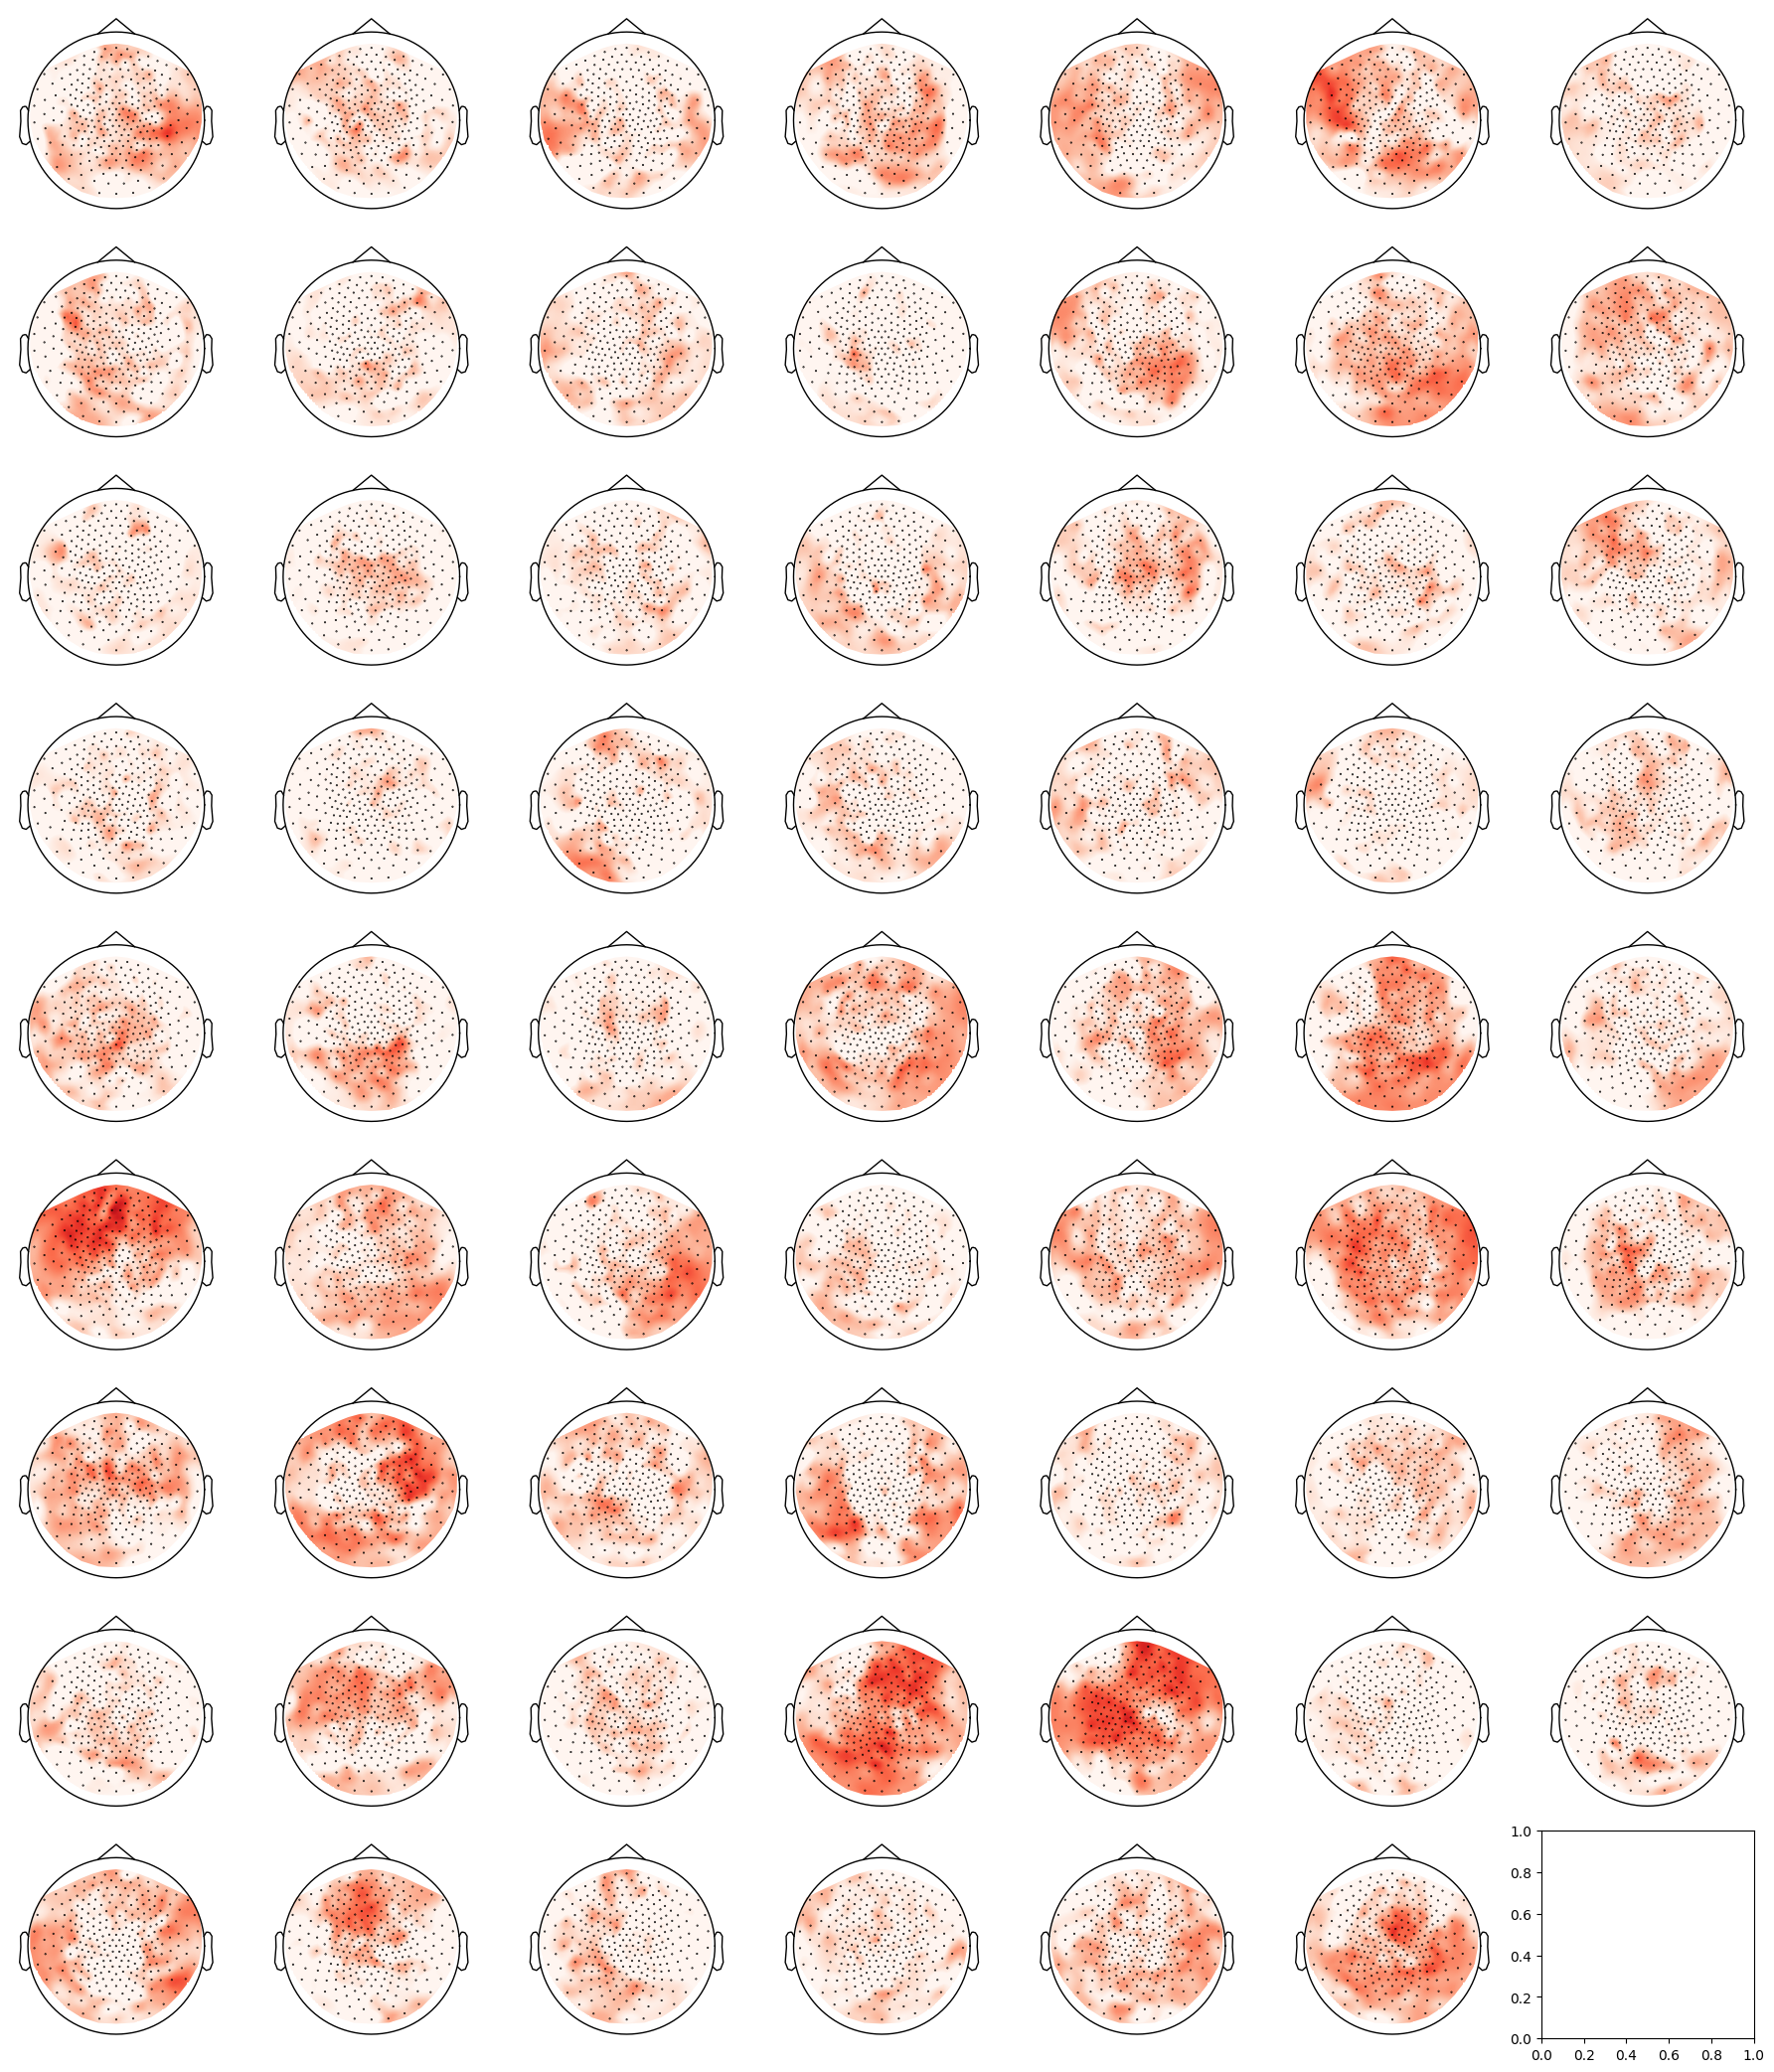

In [12]:
columns = np.floor(np.sqrt(len(full_results.keys()))).astype(int)
rows = np.ceil(len(full_results.keys()) / 7).astype(int)
tp = time_ixes[-2]

f, axes = plt.subplots(rows, columns, figsize=(rows*2, columns*3))
axes = axes.flatten()


sc = []
for ix, k in enumerate(list(full_results.keys())):
    data = full_results[k]
    score_res = np.array([np.mean(i, axis=0) for i in data])
    data = score_res[:, tp]
    sc.append(data)
    delta = viz.plot_topomap(
        data,
        epochs.info,
        sphere=(0, -0.025, 0, 0.195),
        cmap="Reds",
        axes=axes[ix],
        show=False,
        image_interp="cubic",
        cnorm=Normalize(vmin=0.5, vmax=1.0),
        contours=0
    )
    


plt.tight_layout()

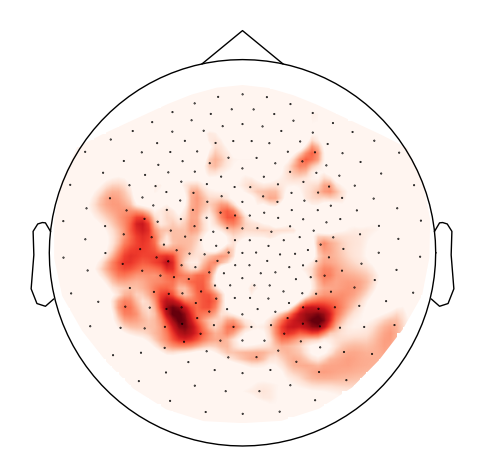

In [13]:
summ = np.mean(sc, axis=0)

f, ax = plt.subplots(1,1, figsize=(6,7))
delta = viz.plot_topomap(
    summ,
    epochs.info,
    sphere=(0, -0.025, 0, 0.195),
    cmap="Reds",
    axes=ax,
    show=False,
    image_interp="cubic",
    cnorm=Normalize(vmin=0.55, vmax=summ.max()*1.0),
    contours=0
)

In [81]:
X = np.array([np.array(full_results[k]).mean(axis=1).T for k in full_results.keys()])

In [95]:
epochs = read_epochs(fif_ar_paths[0][0], preload=False, verbose=False)
ch_adj, ch_names = find_ch_adjacency(epochs.info, ch_type="mag")
off_sens = [(ix, x) for ix, x in enumerate(ch_names) if x not in set(epochs.ch_names)]
off_sens_map = ~(np.arange(275) == off_sens[0][0])
ch_adj_mod = ch_adj[off_sens_map]
ch_adj_mod = ch_adj_mod[:, off_sens_map]

Reading adjacency matrix for ctf275.


In [101]:
threshold_tfce = dict(start=0, step=0.2)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

F_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(
    X-0.5, threshold=threshold_tfce,
    n_permutations=6000, n_jobs=10, out_type="mask", 
    verbose=True, adjacency=ch_adj_mod, buffer_size=None, tail=1
)


stat_fun(H1): min=-4.242546 max=8.338151
Running initial clustering …
Using 42 thresholds from 0.00 to 8.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 72610 clusters


  0%|          | Permuting : 0/5999 [00:00<?,       ?it/s]

In [146]:
cluster_map = np.sum(np.array(clusters)[cluster_pv > 0.05], axis=0).astype(bool)

''

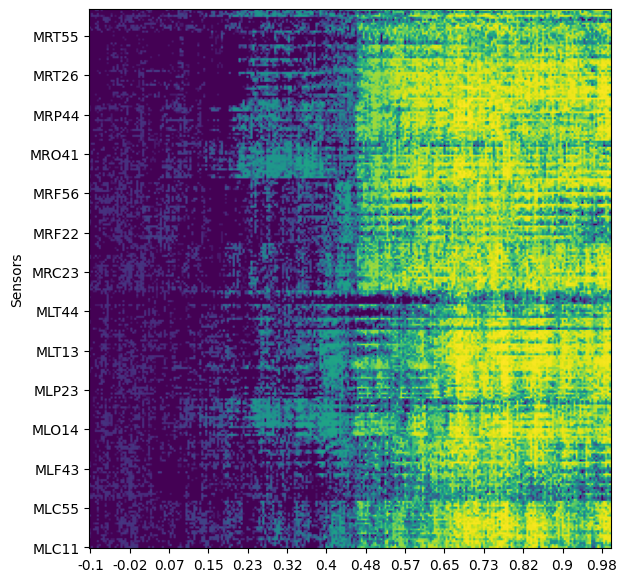

In [139]:
f, ax = plt.subplots(1,1, figsize=(7,7))

ax.imshow(F_obs.T, origin="lower")
ax.set_ylabel("Sensors")
ax.set_yticks(np.arange(len(epochs.ch_names))[::20])
ax.set_yticklabels(epochs.ch_names[::20])
ax.set_xticks(np.arange(len(epochs.times))[::20])
ax.set_xticklabels(np.round(epochs.times[::20],2))
;

''

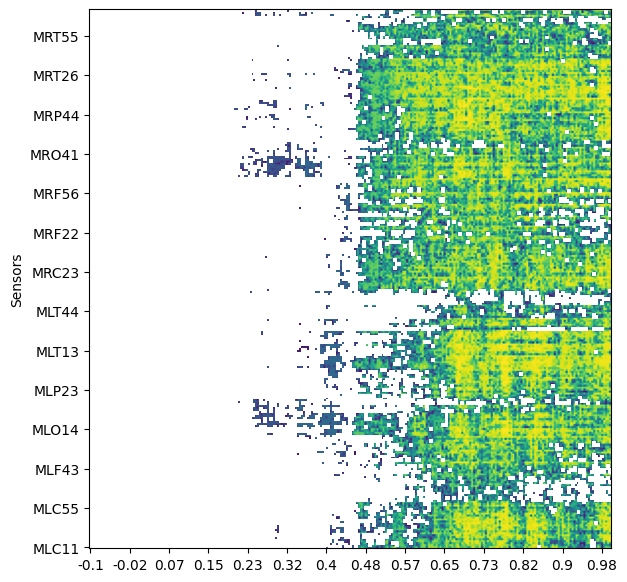

In [153]:
f, ax = plt.subplots(1,1, figsize=(7,7))

F_obs_mod = copy(F_obs)
F_obs_mod[cluster_map] = np.nan

ax.imshow(F_obs_mod.T, origin="lower")
ax.set_ylabel("Sensors")
ax.set_yticks(np.arange(len(epochs.ch_names))[::20])
ax.set_yticklabels(epochs.ch_names[::20])
ax.set_xticks(np.arange(len(epochs.times))[::20])
ax.set_xticklabels(np.round(epochs.times[::20],2))
;

In [155]:
threshold_tfce = dict(start=0, step=0.2)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

F_obs_tt, clusters_tt, cluster_pv_tt, H0_tt = spatio_temporal_cluster_1samp_test(
    X-0.5, threshold=threshold_tfce,
    n_permutations=6000, n_jobs=30, out_type="mask",
    verbose=True, adjacency=ch_adj_mod, buffer_size=None, tail=0
)

stat_fun(H1): min=-4.242546 max=8.338151
Running initial clustering …
Using 42 thresholds from 0.00 to 8.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 72610 clusters


  0%|          | Permuting : 0/5999 [00:00<?,       ?it/s]

In [161]:
np.abs(np.array([F_obs_tt.min(), F_obs_tt.max()]))
TwoSlopeNorm(0, vmin)

array([ 19.91430428, 143.4680736 ])

In [162]:
cluster_map_tt = np.sum(np.array(clusters_tt)[cluster_pv_tt > 0.05], axis=0).astype(bool)

''

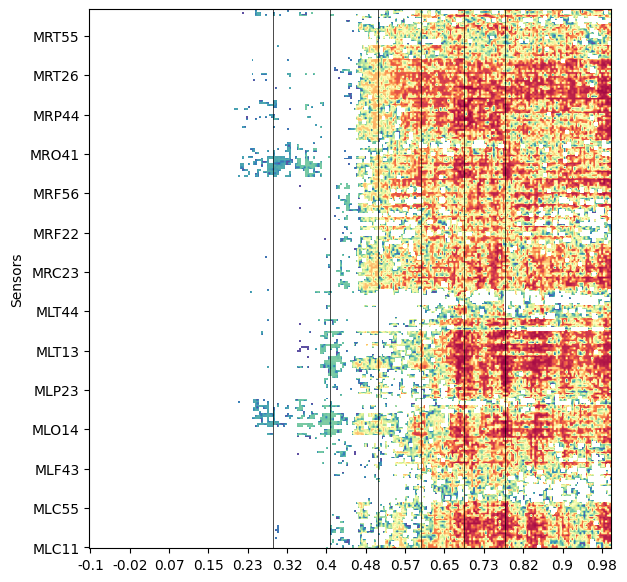

In [229]:
f, ax = plt.subplots(1,1, figsize=(7,7))

F_obs_mod_tt = copy(F_obs_tt)
F_obs_mod_tt[cluster_map_tt] = np.nan
norm_data = F_obs_mod_tt[~np.isnan(F_obs_mod_tt)]
divnorm = TwoSlopeNorm(np.median(norm_data), vmin=norm_data.min(), vmax=norm_data.max())
# divnorm = Normalize(vmin=F_obs_mod_tt.min(), vmax=F_obs_mod_tt.max())

im = ax.imshow(F_obs_mod.T, origin="lower", norm=divnorm, cmap="Spectral_r")
ax.set_ylabel("Sensors")
ax.set_yticks(np.arange(len(epochs.ch_names))[::20])
ax.set_yticklabels(epochs.ch_names[::20])
ax.set_xticks(np.arange(len(epochs.times))[::20])
ax.set_xticklabels(np.round(epochs.times[::20],2))

for t in [0.287, 0.405, 0.505, 0.6, 0.69, 0.777]:
    ax.axvline(np.where(epochs.times >= t)[0][0], color="black", lw=0.5)
;

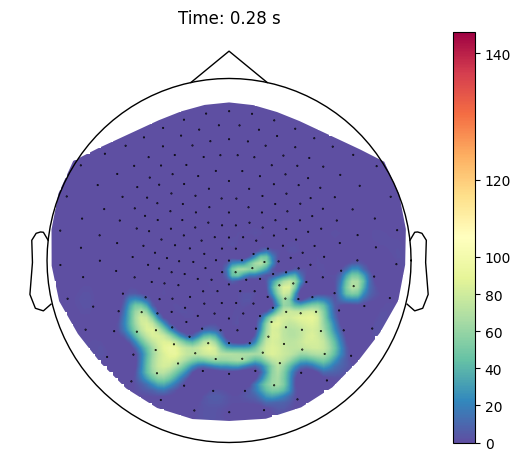

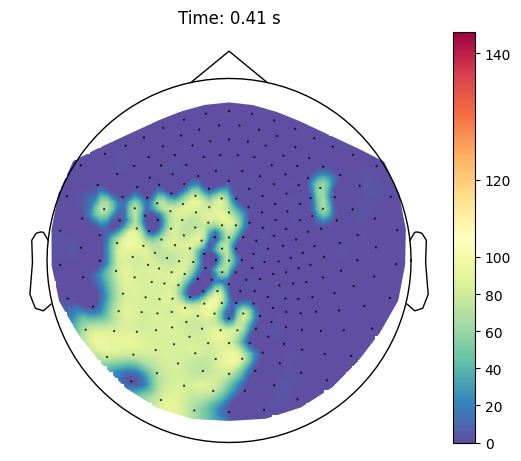

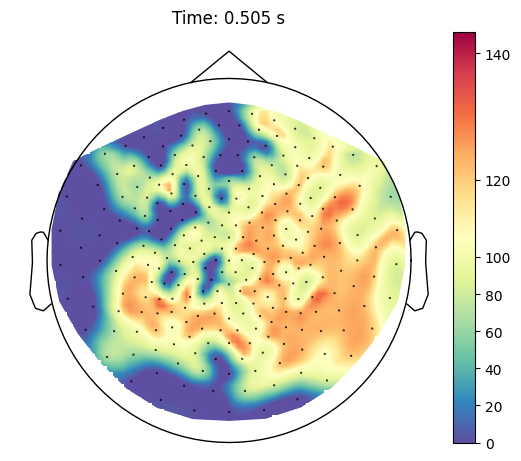

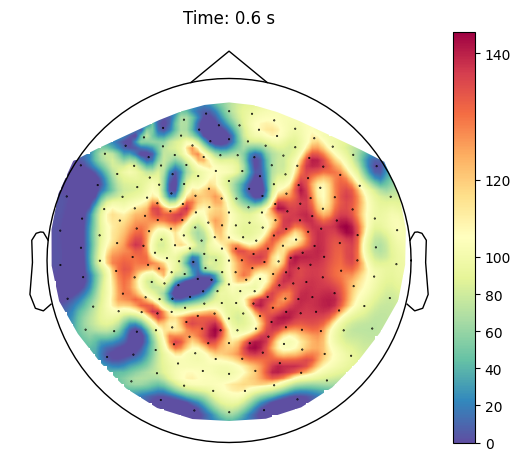

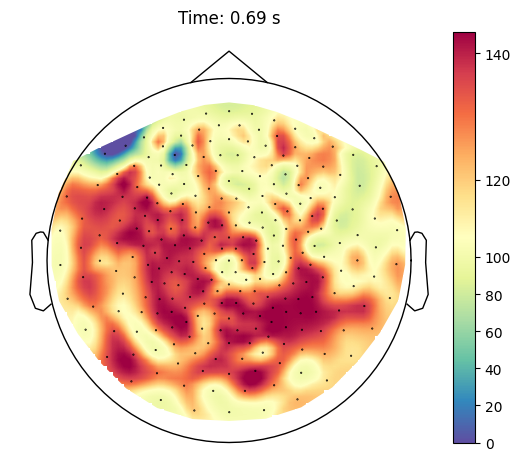

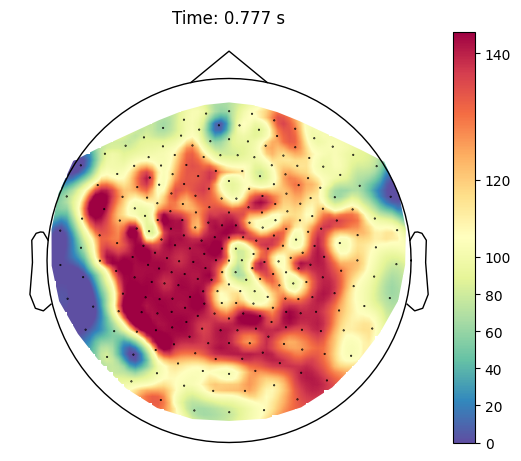

In [242]:
divnorm = TwoSlopeNorm(np.median(norm_data), vmin=0, vmax=norm_data.max())
for t in [0.28, 0.41, 0.505, 0.6, 0.69, 0.777]:
    time_ix = np.where(epochs.times >= t)[0][0]
    f, ax = plt.subplots(1,1, figsize=(6,7))
    data = F_obs_mod_tt[time_ix]
    data[np.isnan(data)] = 0.0
    delta = viz.plot_topomap(
        data,
        epochs.info,
        sphere=(0, -0.025, 0, 0.195),
        cmap="Spectral_r",
        axes=ax,
        show=False,
        image_interp="cubic",
        cnorm=divnorm,
        contours=0
    )
    colorbar(delta[0])
    ax.set_title(f"Time: {t} s")

In [256]:
sc_all = []
for ix, k in enumerate(list(full_results.keys())):
    data = full_results[k]
    score_res = np.array([np.mean(i, axis=0) for i in data])
    sc_all.append(score_res)
sc_all = np.mean(sc_all, axis=0).T

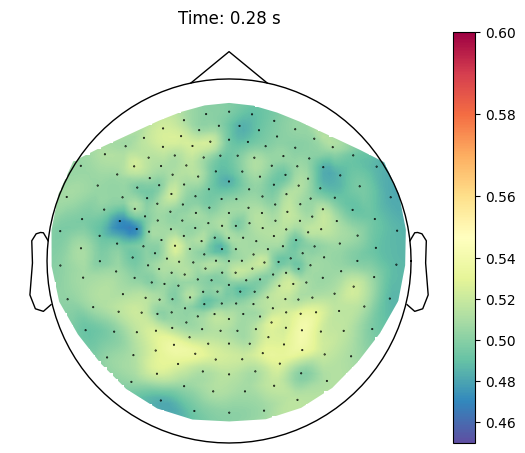

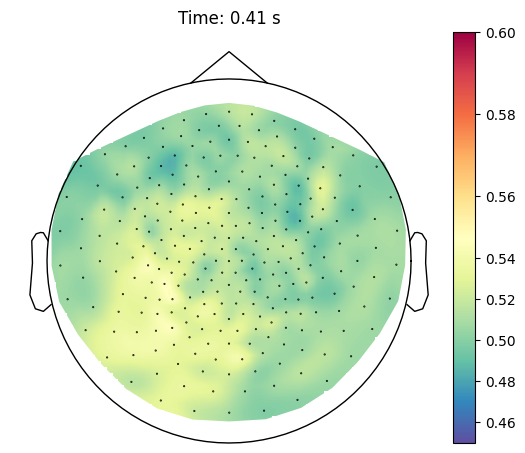

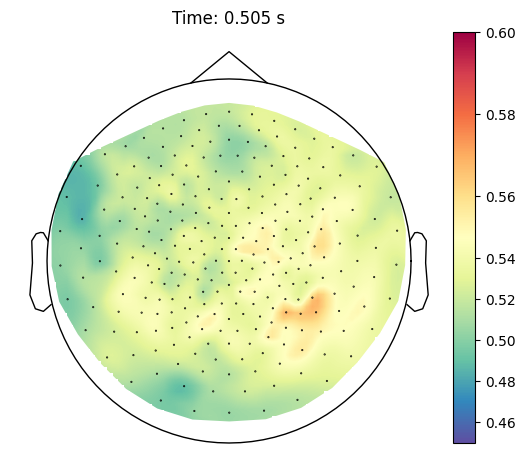

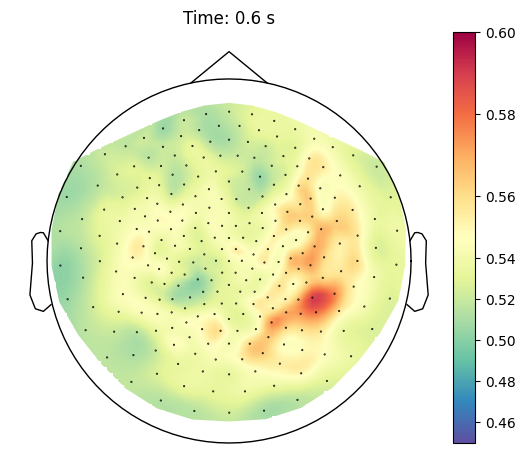

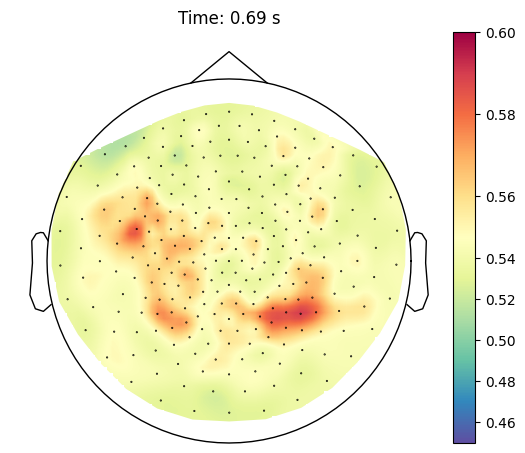

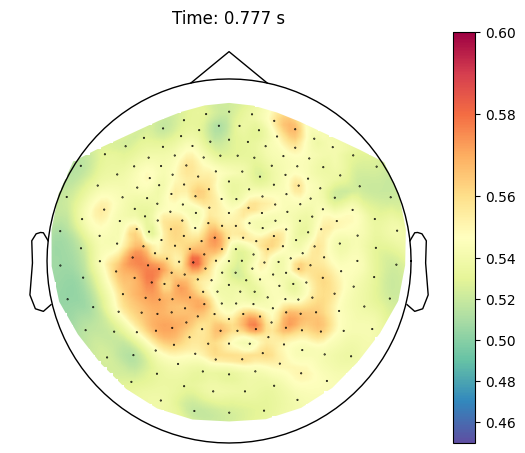

In [276]:
class_perf = copy(sc_all)
# class_perf[cluster_map_tt] = np.nan

mask_dict = dict(
    marker=0, markerfacecolor="w", markeredgecolor="k",
    linewidth=0, markersize=4
)
norm_data = class_perf[~np.isnan(class_perf)]
divnorm = TwoSlopeNorm(0.55, vmin=0.45, vmax=0.60)
for t in [0.28, 0.41, 0.505, 0.6, 0.69, 0.777]:
    time_ix = np.where(epochs.times >= t)[0][0]
    f, ax = plt.subplots(1,1, figsize=(6,7))
    data = class_perf[time_ix]
    data[np.isnan(data)] = 0.0
    delta = viz.plot_topomap(
        data,
        epochs.info,
        sphere=(0, -0.025, 0, 0.195),
        cmap="Spectral_r",
        axes=ax,
        show=False,
        image_interp="cubic",
        cnorm=divnorm,
        contours=0
    )
    colorbar(delta[0])
    ax.set_title(f"Time: {t} s")

In [294]:
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

X_smooth = gaussian_filter1d(X, 2, axis=1)

F_obs_ex, clusters_ex, cluster_pv_ex, H0_ex = spatio_temporal_cluster_1samp_test(
    X_smooth-0.5, threshold=threshold_tfce,
    n_permutations=6000, n_jobs=40, out_type="mask", 
    verbose=True, adjacency=ch_adj_mod, buffer_size=None, tail=0
)

stat_fun(H1): min=-3.956390 max=8.060603
Running initial clustering …
Using 41 thresholds from 0.00 to 8.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 72610 clusters


  0%|          | Permuting : 0/5999 [00:00<?,       ?it/s]

''

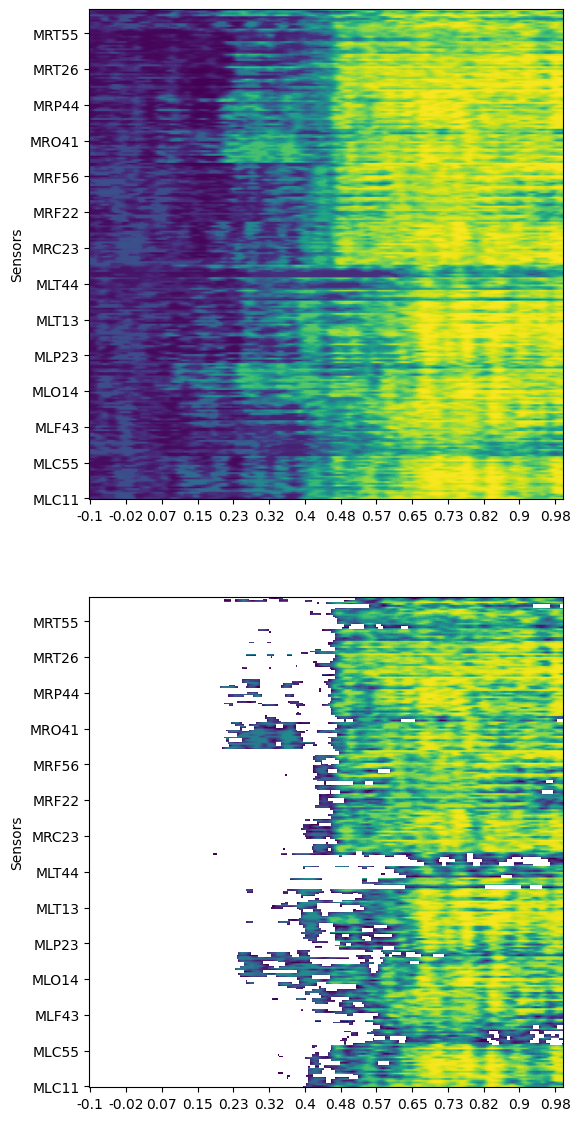

In [295]:
cluster_map_ex = np.sum(np.array(clusters_ex)[cluster_pv_ex > 0.05], axis=0).astype(bool)

f, ax = plt.subplots(2,1, figsize=(7,14))

ax[0].imshow(F_obs_ex.T, origin="lower")
ax[0].set_ylabel("Sensors")
ax[0].set_yticks(np.arange(len(epochs.ch_names))[::20])
ax[0].set_yticklabels(epochs.ch_names[::20])
ax[0].set_xticks(np.arange(len(epochs.times))[::20])
ax[0].set_xticklabels(np.round(epochs.times[::20],2))

F_obs_mod_ex = copy(F_obs_ex)
F_obs_mod_ex[cluster_map_ex] = np.nan

ax[1].imshow(F_obs_mod_ex.T, origin="lower")
ax[1].set_ylabel("Sensors")
ax[1].set_yticks(np.arange(len(epochs.ch_names))[::20])
ax[1].set_yticklabels(epochs.ch_names[::20])
ax[1].set_xticks(np.arange(len(epochs.times))[::20])
ax[1].set_xticklabels(np.round(epochs.times[::20],2))

;

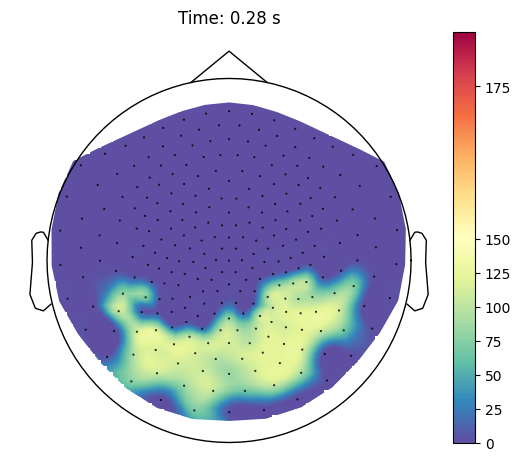

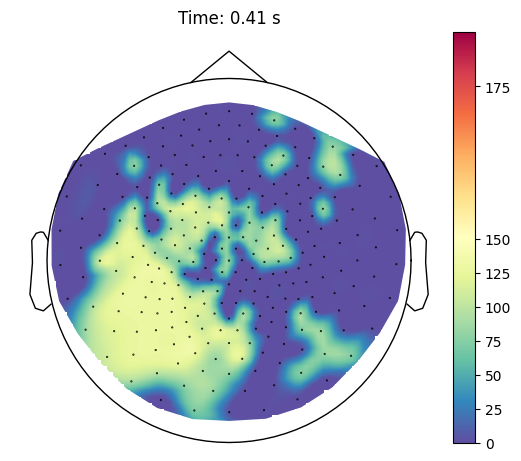

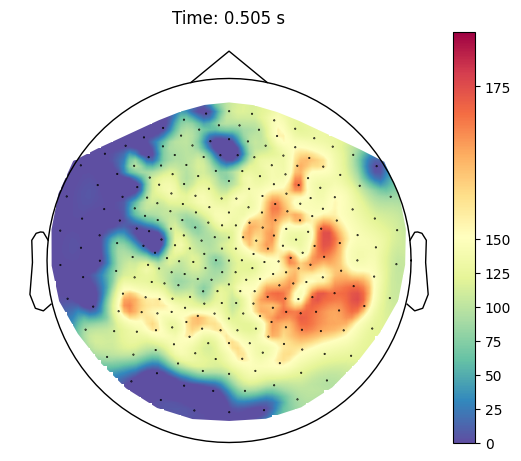

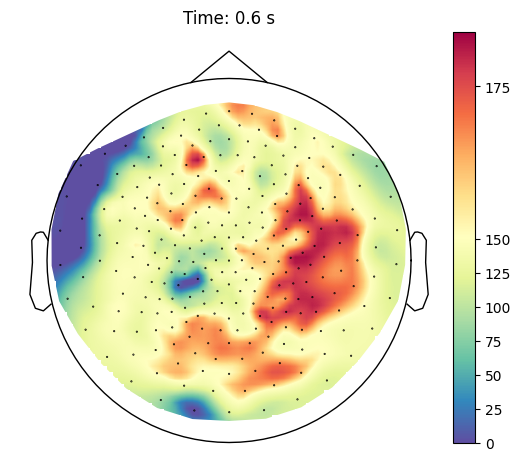

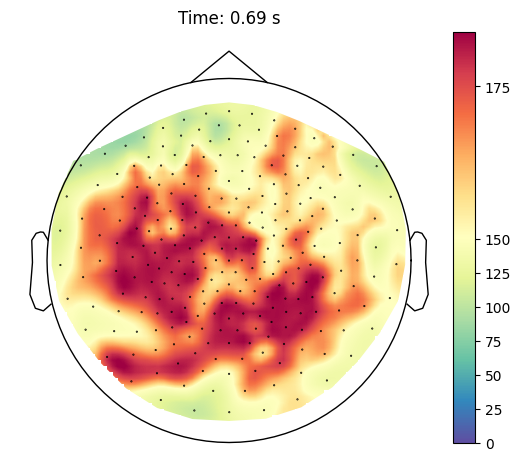

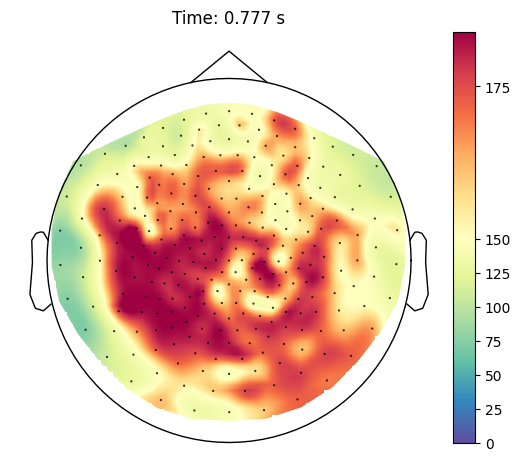

In [302]:
norm_data = F_obs_mod_ex[~np.isnan(F_obs_mod_ex)]
divnorm = TwoSlopeNorm(np.median(norm_data), vmin=0, vmax=norm_data.max())
for t in [0.28, 0.41, 0.505, 0.6, 0.69, 0.777]:
    time_ix = np.where(epochs.times >= t)[0][0]
    f, ax = plt.subplots(1,1, figsize=(6,7))
    data = F_obs_mod_ex[time_ix]
#     data[np.isnan(data)] = 0.0
    delta = viz.plot_topomap(
        data,
        epochs.info,
        sphere=(0, -0.025, 0, 0.195),
        cmap="Spectral_r",
        axes=ax,
        show=False,
        image_interp="cubic",
        cnorm=divnorm,
        contours=0
    )
    colorbar(delta[0])
    ax.set_title(f"Time: {t} s")